# STEP1 : Define Goal
### Make models that predict passengers survival chance 

# STEP2 : Get Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier  

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold, ShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline, make_pipeline

org_titanic = pd.read_csv('./data/train.csv')
main_df = org_titanic.copy()

# EDA

In [2]:
org_titanic.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


Survival Rate : 0.38


<AxesSubplot:title={'center':'Survival'}, ylabel='Number of Passengers'>

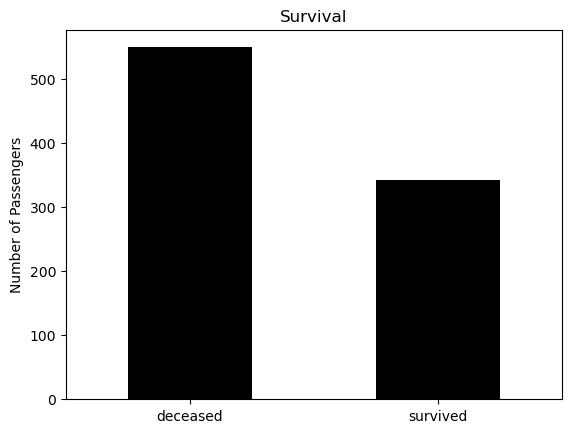

In [3]:
print('Survival Rate :', round(org_titanic['Survived'].mean(),2))
org_titanic['Survived'].replace(0, 'deceased').replace(1, 'survived').value_counts().plot(kind='bar',
                                                                                          color='black',
                                                                                          title='Survival',
                                                                                          ylabel='Number of Passengers',
                                                                                          rot=0)

### Pclass

Precentage of Total Passengers:
3    0.55
1    0.24
2    0.21
Name: Pclass, dtype: float64


<AxesSubplot:title={'center':'Total Passengers'}, xlabel='Pclass', ylabel='%'>

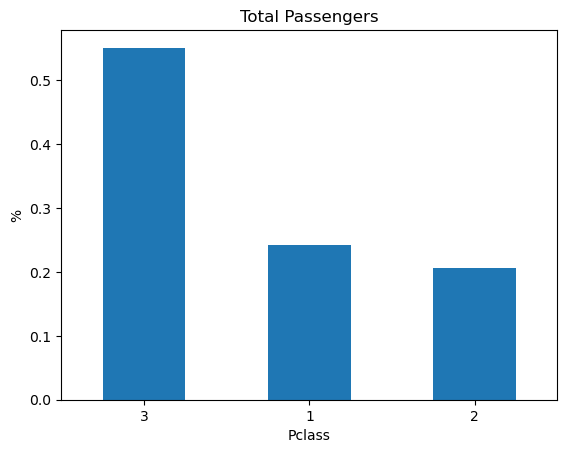

In [4]:
print('Precentage of Total Passengers:')
print(round(org_titanic['Pclass'].value_counts()/org_titanic['Pclass'].count(),2))
(org_titanic['Pclass'].value_counts()/org_titanic['Pclass'].count()).plot(kind='bar',
                                                                          title='Total Passengers',
                                                                          xlabel='Pclass',
                                                                          ylabel='%',
                                                                          rot=0)

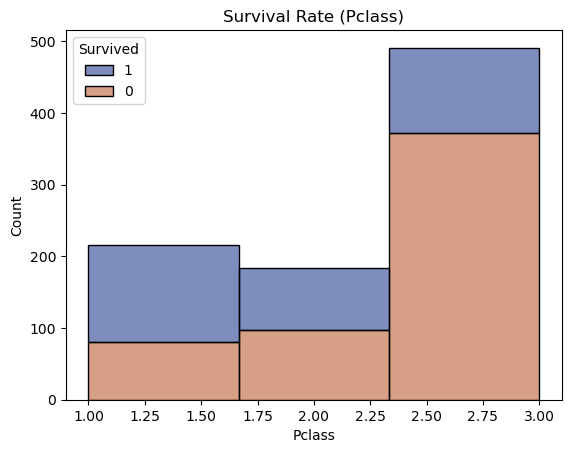

In [39]:
# plotting with seaborn
sns.histplot(data=org_titanic,
             x='Pclass',
             stat='count',
             hue='Survived',
             palette='dark',
             hue_order=[1,0],
             alpha=0.5,
             bins=3,
             multiple="stack").set(title='Survival Rate (Pclass)')
plt.show()

Survival % per Pclass :
Pclass
1    0.63
2    0.47
3    0.24
Name: Survived, dtype: float64


<AxesSubplot:title={'center':'Survival Rate (Pclass)'}, xlabel='Pclass', ylabel='%'>

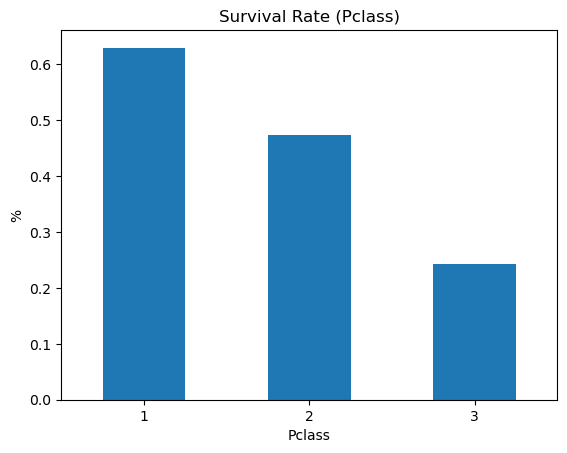

In [6]:
print('Survival % per Pclass :')
print(round(org_titanic.groupby('Pclass')['Survived'].mean(),2))
org_titanic.groupby('Pclass')['Survived'].mean().plot(kind='bar',
                                                      title='Survival Rate (Pclass)',
                                                      ylabel='%',
                                                      xlabel='Pclass',
                                                      rot=0)

### Sex

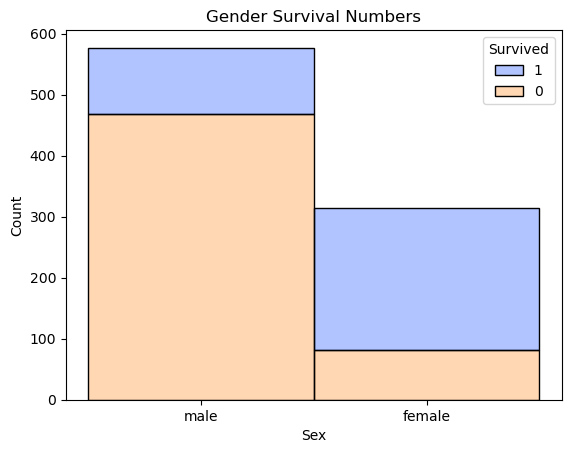

In [37]:
sns.histplot(data=org_titanic,
             x='Sex',
             stat='count',
             hue='Survived',
             palette='bright',
             hue_order=[1,0],
             alpha=0.3,
             bins=2,
             multiple="stack").set(title='Gender Survival Numbers')
plt.show()

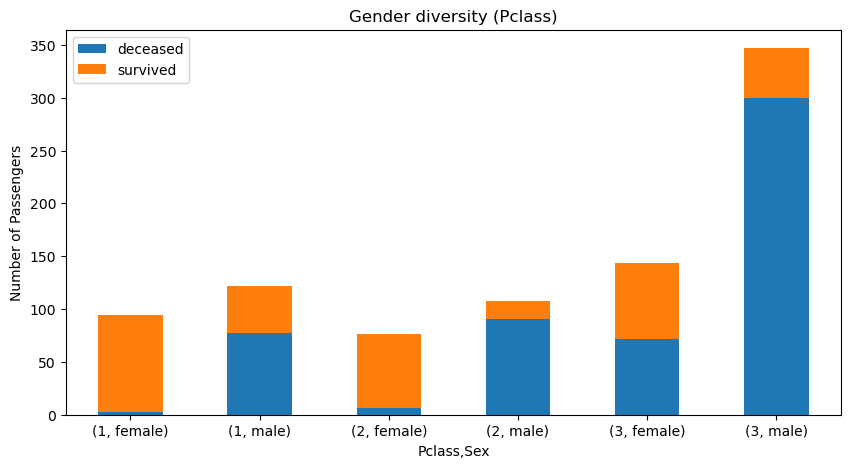

In [7]:
org_titanic.groupby(['Pclass', 'Sex','Survived']).size().unstack().plot.bar(title='Gender diversity (Pclass)', 
                                                                 ylabel='Number of Passengers',
                                                                 rot=0,
                                                                 stacked=True,
                                                                 figsize=(10,5))
plt.legend(['deceased','survived'])
plt.show()

### Age

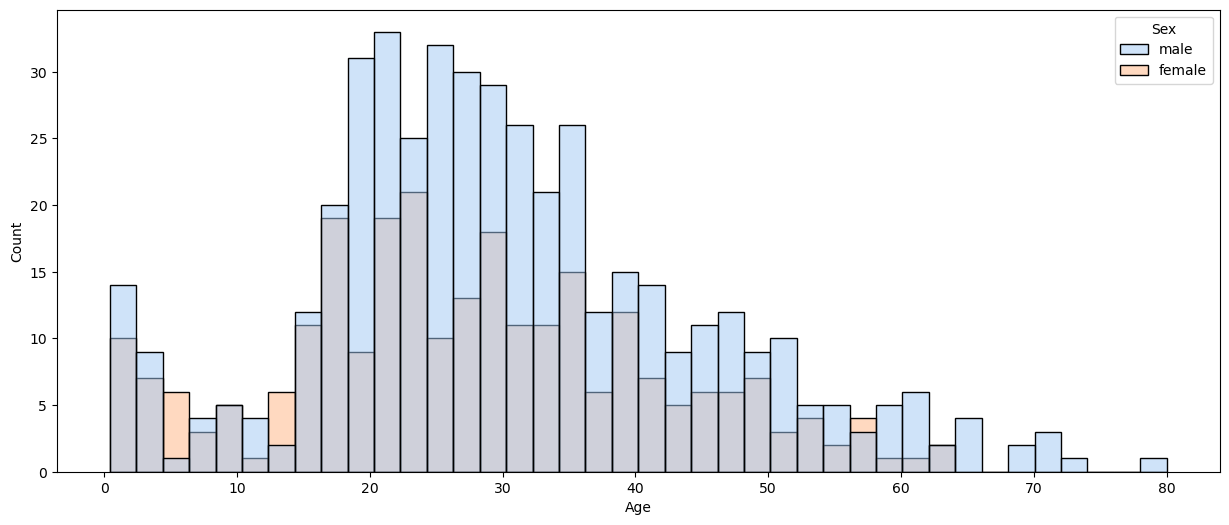

In [26]:
fig, ax = pyplot.subplots(figsize=(15,6))
sns.histplot(data=org_titanic,
             x='Age',
             stat='count',
             hue='Sex',
             palette='pastel',
             hue_order=['male','female'],
             alpha=0.5,
             bins=40)
plt.show()

Average Age of Survived and Deceased Passengers :
Survived
0    30
1    28
Name: Age, dtype: int64


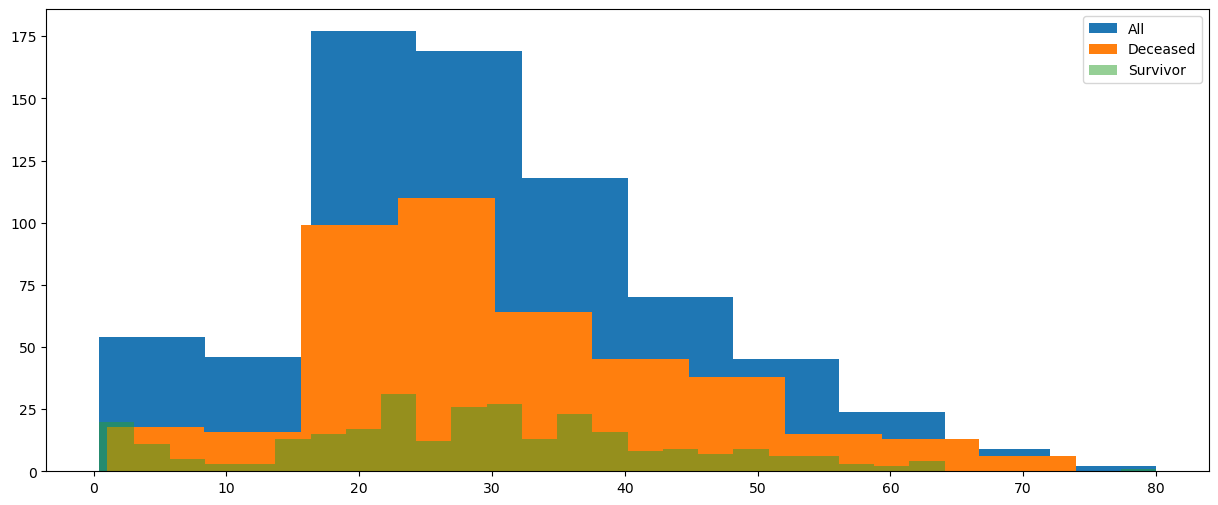

In [9]:
print('Average Age of Survived and Deceased Passengers :')
print(org_titanic.groupby('Survived')['Age'].mean().astype('int64'))

org_titanic.loc[:,'Age'].hist()
org_titanic.loc[org_titanic['Survived'] == 0, 'Age'].hist()
org_titanic.loc[org_titanic['Survived'] == 1, 'Age'].hist(alpha=0.5,
                                                          figsize=(15,6),
                                                          bins=30,
                                                          grid=False)
plt.legend(['All', 'Deceased', 'Survivor'])
plt.show()

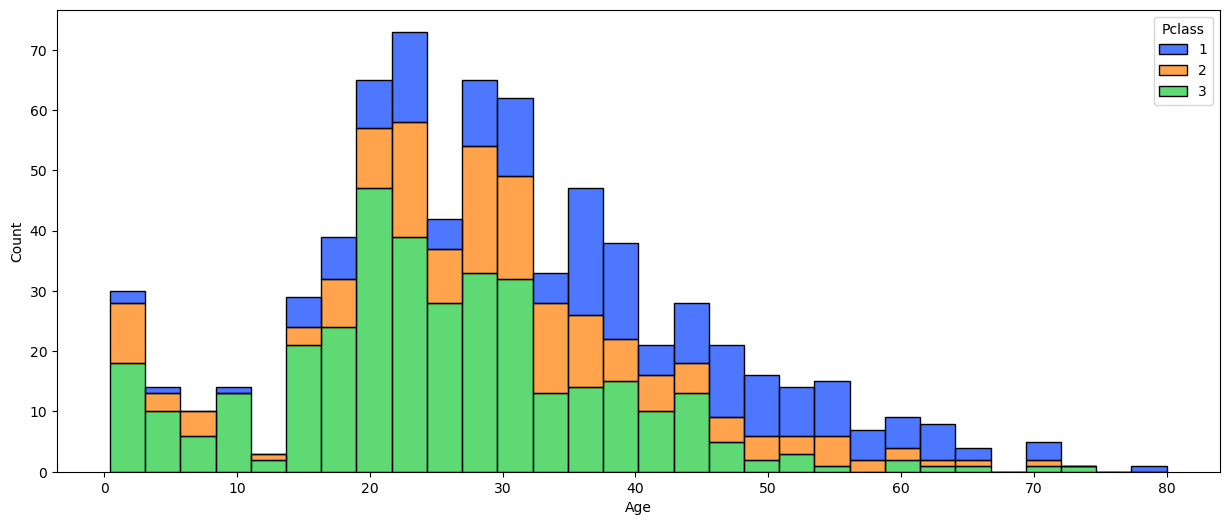

In [35]:
fig, ax = pyplot.subplots(figsize=(15,6))
sns.histplot(data=org_titanic,
             x='Age',
             stat='count',
             hue='Pclass',
             palette='bright',
             alpha=0.7,
             bins=30, 
             multiple="stack")
plt.show()

In [15]:
org_titanic['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [ ]:
org_titanic.groupby(['Sex', 'Pclass']).size().unstack().plot(kind='bar')
plt.show()

# STEP2: EDA

### Check missing values
- **Age** 173 missing values.
- In **Cabin** almost 75% data missing! Care to use!
- **Embarked** has 2 missing values

In [ ]:
print(org_titanic.info())
sns.heatmap(org_titanic.isna())

### Check unique values
- (**Passenger Id** vs **Name**), **Survived**, **Pclass**, **Sex**, **Embarked**: number of unique values look OK.
- Some **Ticket**s include more than one person.
- Max value of **SibSp** vs **Parch** also fit to each other
- Some **Cabin** number did not specified for the passenger but the group. One can still assume the cabins are located close to each other. 
- **Fare** looks like total price for the group ticket

In [ ]:
org_titanic.nunique()

## Prior Feature Engineering: Create new features

In [ ]:
def title_name(df):
    '''
    Partition Name feature to: title, first, last, middle name features
    '''    
    main_df[['title', 'first', 'last', 'middle']] = ''
    
    i=0
    for name in df['Name']:
        i_char = name.find(', ')
        f_char = name.find('. ')
        df['last'].iloc[i] = name[:i_char]
        df['first'].iloc[i]  = name[f_char+2:]
        df['title'].iloc[i] = name[i_char+2:f_char+1]
        
        q = name.find(' (')
        if q != -1:
            df['middle'].iloc[i] = name[q:]
            df['first'].iloc[i]   = name[f_char+2:q]
        q = name.find(' "')
        
        if q != -1:
            df['middle'].iloc[i] = name[q:]
            df['first'].iloc[i]   = name[f_char+2:q]         
            

        i=i+1
    
    return df

In [ ]:
def prices(df):
    '''
    Some passengers with the same Ticket has slightly different Fares. Take average and round the values. 
    Nice aggregation practice! 
    '''
    df['Price'] = 0
    
    g = df.groupby('Ticket')['Fare']
    df['Price'] = g.transform('mean').astype('int64')
    
    return df
    
thy=prices(main_df)

In [ ]:
def groups(df):
    '''
    Define passenger groups/families that have same ticket and calculate Surviving ratio of the individuals in the groups.
    '''
    grp = df.groupby('Ticket')
    df['GrpSize']    = grp['Ticket'].transform('count')
    df['GCausality'] = grp['Survived'].transform('mean')
    
    return df

In [ ]:
main_df1 = title_name(main_df)
main_df2 = prices(main_df1)
main_df3 = groups(main_df2)

## Explore Data - Features

    **Survival  - Survival (0 = No; 1 = Yes). Not included in test.csv file.
    **Pclass    - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
    **Name      - Name
    **Sex       - Sex
    **Age       - Age
    **Sibsp     - Number of Siblings/Spouses Aboard
    **Parch     - Number of Parents/Children Aboard
    **Ticket    - Ticket Number
    **Fare      - Passenger Fare
    **Cabin     - Cabin
    **Embarked  - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
    
    *Title      - Title ('Mr.', 'Mrs.', 'Miss.', 'Master.', 'Don.', 'Rev.', 'Dr.', 'Major.','Lady.', 'Sir.', 'Col.', 'Capt.', 'the Countess.', 'Jonkheer.')
    *First      - First name
    *Last       - Last name
    *Middle     - Rest of the name
    *Price      - Given ticket price
    *GrpSize    - Number of individual in groups/families, groupby ticket
    *GCasualty - Surviving ratio in a group
    
    

In [ ]:
sns.pairplot(main_df3, y_vars='Pclass', x_vars=['Age', 'Price', 'GrpSize', 'GCausality', 'Parch', 'SibSp'], hue='Survived')

### **'title'**

Some titles can be combined--> 
-  Mrs.  = Ms.+ Mme. 
-  Miss. = Mlle.+Ms.(even not clear mariage status, more Miss. exist)

In [ ]:
main_df3['title'].value_counts()

In [ ]:
main_df3.loc[main_df3['title'].isin(['Mme.']), 'title']        = 'Mrs.'
main_df3.loc[main_df3['title'].isin(['Mlle.','Ms.']), 'title'] = 'Miss.'
main_df3['title'].unique()

### '**Embarked**'

There are **two missing values** in Embarked. The missing values belong to the Ticket=113572. Similar serial_numbers belong to S and C. Mainly S ...
**So set them to 'S'**

In [ ]:
main_df3.sort_values('Ticket')[29:51]

In [ ]:
main_df3[main_df3['Embarked'].isna()]

In [ ]:
main_df3.loc[main_df3['Embarked'].isna(), 'Embarked'] = 'S'
main_df3[main_df3['Embarked'].isna()]

### '**Age**'

#### Missing values is filled according to title of the passenger. Avarage ages for different title group:

In [ ]:
main_df3.groupby('title')['Age'].mean().astype('int64')

#### **To be sure that it is a good assumption:** check ratio: number of missing (Age) values/total number.
Highest for Mr. with 23%. Eventhough it is quite high, lets assume it is OK for our purpose.

In [ ]:
print('Mr.: ',     round(119/517,2))
print('Mrs.: ',    round(17/126,2))
print('Miss.: ',   round(36/185,2))
print('Master.: ', round(4/40,2))
print('Dr.: ',     round(1/7,2))

In [ ]:
# Number of passengers
print(main_df3['title'].value_counts())
#Number of missing 'Age' value by title
main_df3.loc[main_df3['Age'].isna()]['title'].value_counts()

#### Ampute missin 'Age' values according to 'title' :

In [ ]:
main_df3.loc[(main_df3['Age'].isna()) & (main_df3['title']=='Mr.'), 'Age']     = main_df3.loc[main_df3['title'] == 'Mr.']['Age'].mean()
main_df3.loc[(main_df3['Age'].isna()) & (main_df3['title']=='Miss.'), 'Age']   = main_df3.loc[main_df3['title'] == 'Miss.']['Age'].mean()
main_df3.loc[(main_df3['Age'].isna()) & (main_df3['title']=='Mrs.'), 'Age']    = main_df3.loc[main_df3['title'] == 'Mrs.']['Age'].mean()
main_df3.loc[(main_df3['Age'].isna()) & (main_df3['title']=='Master.'), 'Age'] = main_df3.loc[main_df3['title'] == 'Master.']['Age'].mean()
main_df3.loc[(main_df3['Age'].isna()) & (main_df3['title']=='Dr.'), 'Age']     = main_df3.loc[main_df3['title'] == 'Dr.']['Age'].mean()

#Check, there is no missing values left:
main_df3.loc[main_df3['Age'].isna()]

# STEP3: Modeling

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(main_df3.corr().abs(), annot=True) 
# We only care absolute values, not vector direction: abs()
# annot for the written values